# Bayesian Model for 1 Nominal Predictor (Feature)

## 1). Load required libaraies

In [14]:
#Libs and File-wide Constants
library(rjags)
library(runjags)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(dplyr)
library(binr)
library(readr)
library(jsonlite)
library(LaplacesDemon)
library(mosaicCore)
testjags()

You are using R version 4.1.3 (2022-03-10) on a windows machine, with
the RTerm GUI
JAGS version 4.3.0 found successfully using the command
'C:/Programs/JAGS/x64/bin/jags-terminal.exe'
The rjags package is installed


## 2). Define constants

In [15]:
features = c("Hue","Length","Shape")
elementNums = c("12","48", "192","768")
spatialPatterns = c("Gridded","Random")
centerOrPeriph = c("Center","Periphery")
columns_to_keep = c('PID','ReactionTime','ReactionTimeLog','Feature','ElemNum','SpatialPattern','CenterOrPeriph','Target2CenterDis')

# Task analysis constants
# current_task=2
# current_task_short_name= all_tasks_short_names[[current_task]]
# current_analysis_name ="Main"
# current_task_name = all_tasks[[current_task]]
# cat("Active task under analysis:",current_task_name,"(",current_task,")")


# Path constants
mcmcDir = "calculatedMCMCs/"
resultsDir = "results/"
resultsGraphicsDir = "graphicResults/"

## 3). Include plot functions from Kruchke and Miguel

In [16]:
# Functions adapted from Kruchke's code

DbdaAcfPlot = function( codaObject , parName=varnames(codaObject)[1] , plColors=NULL ) 
{
  if ( all( parName != varnames(codaObject) ) ) { 
    stop("parName must be a column name of coda object")
  }
  nChain = length(codaObject)
  if ( is.null(plColors) ) plColors=1:nChain
  xMat = NULL
  yMat = NULL
  for ( cIdx in 1:nChain ) {
    acfInfo = acf(codaObject[,c(parName)][[cIdx]],plot=FALSE) 
    xMat = cbind(xMat,acfInfo$lag)
    yMat = cbind(yMat,acfInfo$acf)
  }
  matplot( xMat , yMat , type="o" , pch=20 , col=plColors , ylim=c(0,1) ,
           main="" , xlab="Lag" , ylab="Autocorrelation" )
  abline(h=0,lty="dashed")
  EffChnLngth = effectiveSize(codaObject[,c(parName)])
  text( x=max(xMat) , y=max(yMat) , adj=c(1.0,1.0) , cex=1.25 ,
        labels=paste("ESS =",round(EffChnLngth,1)) )
}

DbdaDensPlot = function( codaObject , parName=varnames(codaObject)[1] , plColors=NULL ) {
  if ( all( parName != varnames(codaObject) ) ) { 
    stop("parName must be a column name of coda object")
  }
  nChain = length(codaObject) # or nchain(codaObject)
  if ( is.null(plColors) ) plColors=1:nChain
  xMat = NULL
  yMat = NULL
  hdiLims = NULL
  for ( cIdx in 1:nChain ) {
    densInfo = density(codaObject[,c(parName)][[cIdx]]) 
    xMat = cbind(xMat,densInfo$x)
    yMat = cbind(yMat,densInfo$y)
    hdiLims = cbind(hdiLims,HDIofMCMC(codaObject[,c(parName)][[cIdx]]))
  }
  matplot( xMat , yMat , type="l" , col=plColors , 
           main="" , xlab="Param. Value" , ylab="Density" )
  abline(h=0)
  points( hdiLims[1,] , rep(0,nChain) , col=plColors , pch="|" )
  points( hdiLims[2,] , rep(0,nChain) , col=plColors , pch="|" )
  text( mean(hdiLims) , 0 , "95% HDI" , adj=c(0.5,-0.2) )
  EffChnLngth = effectiveSize(codaObject[,c(parName)])
  MCSE = sd(as.matrix(codaObject[,c(parName)]))/sqrt(EffChnLngth) 
  text( max(xMat) , max(yMat) , adj=c(1.0,1.0) , cex=1.25 ,
        paste("MCSE =\n",signif(MCSE,3)) )
}
    
HDIofMCMC = function( sampleVec , credMass=0.95 ) {
  # Computes highest density interval from a sample of representative values,
  #   estimated as shortest credible interval.
  # Arguments:
  #   sampleVec
  #     is a vector of representative values from a probability distribution.
  #   credMass
  #     is a scalar between 0 and 1, indicating the mass within the credible
  #     interval that is to be estimated.
  # Value:
  #   HDIlim is a vector containing the limits of the HDI
  sortedPts = sort( sampleVec )
  ciIdxInc = ceiling( credMass * length( sortedPts ) )
  nCIs = length( sortedPts ) - ciIdxInc
  ciWidth = rep( 0 , nCIs )
  for ( i in 1:nCIs ) {
    ciWidth[ i ] = sortedPts[ i + ciIdxInc ] - sortedPts[ i ]
  }
  HDImin = sortedPts[ which.min( ciWidth ) ]
  HDImax = sortedPts[ which.min( ciWidth ) + ciIdxInc ]
  HDIlim = c( HDImin , HDImax )
  return( HDIlim )
}

diagMCMC = function( codaObject , parName=varnames(codaObject)[1] ,
                     saveName=NULL , saveType="jpg", parAltName=NULL ) {
# Note: original version by Kruchke
    
  if (is.null(parAltName)) {
      parAltName = parName
  }
  DBDAplColors = c("red","green","blue","cyan","magenta","yellow","black","purple")
  # openGraph(height=5,width=7)
  par( mar=0.5+c(3,4,1,0) , oma=0.1+c(0,0,2,0) , mgp=c(2.25,0.7,0) , 
       cex.lab=1.5 )
  layout(matrix(1:4,nrow=2))
  # traceplot and gelman.plot are from CODA package:
  require(coda)
  verticalAxisName = paste("Param. Value of ",parAltName,"")
  coda::traceplot( codaObject[,c(parName)] , main="" , ylab="Param. Value" ,
                   col=DBDAplColors ) 
  tryVal = try(
    coda::gelman.plot( codaObject[,c(parName)] , main="" , auto.layout=FALSE , 
                       col=DBDAplColors )
  )  
  # if it runs, gelman.plot returns a list with finite shrink values:
  if ( class(tryVal)=="try-error" ) {
    plot.new() 
    print(paste0("Warning: coda::gelman.plot fails for ",parName))
  } else { 
    if ( class(tryVal)=="list" & !is.finite(tryVal$shrink[1]) ) {
      plot.new() 
      print(paste0("Warning: coda::gelman.plot fails for ",parName))
    }
  }
  DbdaAcfPlot(codaObject,parName,plColors=DBDAplColors)
  DbdaDensPlot(codaObject,parName,plColors=DBDAplColors)
  mtext( text=parAltName , outer=TRUE , adj=c(0.5,0.5) , cex=2.0 )
}


calcAndPlotContrasts = function(coda,dataFrame,xName) {
  xlevels = levels(as.factor(dataFrame[,xName])) 
  str(xlevels)
  matData = as.matrix(coda,chains=TRUE)    
  numericOutput = list()  
    
  for (i in 1:length(xlevels)) {
      nameCol = xlevels[i]
      numericOutput[[nameCol]] = list()
      
      for (j in 1:length(xlevels)) {
          nameRow = xlevels[j]
          
          # print(paste("i,j:",nameCol,nameRow))
          title = paste(nameCol,"-",nameRow)
          if (j>i) {
               numericOutput[[nameCol]][[nameRow]] = plotAndCalcDifference(matData=matData,i=i,j=j,title=title)
              
          }          
      }
  }
  return(numericOutput)    
}

plotAndCalcDifference = function(matData,i,j,title,varRootName = "b",verbose = TRUE) {
    
    output = list()
    
    varName1 = paste(varRootName,"[",i,"]",sep="")
    varName2 = paste(varRootName,"[",j,"]",sep="")      
    myDiff = matData[,varName1] - matData[,varName2]
    plotPost(myDiff,main=title)
    
    # calculated variables
    probVar1Larger = mean(as.numeric(myDiff>0))
    
    output["probVar1Larger"] = probVar1Larger
    
    if (verbose) {
        print(paste(title,"probVar1Larger:",probVar1Larger))
    }
    
    return(output)
}

smryMCMC = function(  codaSamples , datFrm=NULL , xName=NULL ,
                      contrasts=NULL , saveName=NULL ) {
  # All single parameters:
  parameterNames = varnames(codaSamples) 
  if ( !is.null(datFrm) & !is.null(xName) ) {
    xlevels = levels(as.factor(datFrm[,xName]))
  }
  summaryInfo = NULL
  mcmcMat = as.matrix(codaSamples,chains=TRUE)
  for ( parName in parameterNames ) {
    summaryInfo = rbind( summaryInfo , summarizePost( mcmcMat[,parName] ) )
    thisRowName = parName
    if ( !is.null(datFrm) & !is.null(xName) ) {
      # For row name, extract numeric digits from parameter name. E.g., if
      # parameter name is "beta[12,34]" then pull out 12 and 34:
      levelVal = as.numeric( 
        grep( "^[1-9]" , # grep only substrings that begin with digits.
              # Return sll substrings split by "[" or "," or "]":
              unlist( strsplit( parName , "\\[|,|\\]"  ) ) , 
              value=TRUE ) )
      if ( length(levelVal) > 0 ) { 
        # Assumes there is only a single factor, i.e., levelVal has only entry: 
        thisRowName = paste(thisRowName,xlevels[levelVal]) 
      }
    }
    rownames(summaryInfo)[NROW(summaryInfo)] = thisRowName
  }
  # All contrasts:
  if ( !is.null(contrasts) ) {
    if ( is.null(datFrm) | is.null(xName) ) {
      show(" *** YOU MUST SPECIFY THE DATA FILE AND FACTOR NAMES TO DO CONTRASTS. ***\n")
    } else {
      for ( cIdx in 1:length(contrasts) ) {
        thisContrast = contrasts[[cIdx]]
        left = right = rep(FALSE,length(xlevels))
        for ( nIdx in 1:length( thisContrast[[1]] ) ) { 
          left = left | xlevels==thisContrast[[1]][nIdx]
        }
        left = normalize(left)
        for ( nIdx in 1:length( thisContrast[[2]] ) ) { 
          right = right | xlevels==thisContrast[[2]][nIdx]
        }
        right = normalize(right)
        contrastCoef = matrix( left-right , ncol=1 )
        postContrast = ( mcmcMat[,paste("b[",1:length(xlevels),"]",sep="")] 
                         %*% contrastCoef )
        summaryInfo = rbind( summaryInfo , 
                             summarizePost( postContrast ,
                                            compVal=thisContrast$compVal ,
                                            ROPE=thisContrast$ROPE ) )
        rownames(summaryInfo)[NROW(summaryInfo)] = (
          paste( paste(thisContrast[[1]],collapse=""), ".v.",
                 paste(thisContrast[[2]],collapse=""),sep="") )
      }
    }
  }
  # Save results:
  if ( !is.null(saveName) ) {
    write.csv( summaryInfo , file=paste(saveName,"SummaryInfo.csv",sep="") )
  }
  return( summaryInfo )
}

## 4). Read data

In [17]:
folder = "data/"
files = list.files(path = folder, pattern="*\\.csv$")

allDFList = list()

for (myFile in files) {
  myDF = read.csv(file = paste(folder,myFile,sep=""),sep=",", na.strings = c("null"))
  myDF <- subset(myDF, !is.na(ReactionTime))
  myDF$ElemNum <- factor(myDF$ElemNum)    ## Convert the 'ElemNum' column to a factor (nominal)
  allDFList[[length(allDFList)+1]]=myDF
}
df = do.call("rbind",allDFList)

df = df[columns_to_keep]
head(df)

,PID,ReactionTime,ReactionTimeLog,Feature,ElemNum,SpatialPattern,CenterOrPeriph,Target2CenterDis
,<int>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<chr>,<dbl>
1,3,1507.0,3.178113,Shape,768,Random,Center,0.1064987
2,3,7632.6,3.882673,Shape,768,Random,Center,0.2290965
3,3,23285.2,4.367080,Shape,768,Random,Center,0.1701157
4,3,33382.0,4.523512,Shape,768,Random,Periphery,0.6543107
5,3,7686.5,3.885729,Shape,768,Random,Center,0.2362122
6,3,5805.3,3.763825,Shape,768,Random,Periphery,0.2963505


## 5). Define the function that run MCMC model, return a coda

In [18]:
runMCMC = function(data,
                          modelString,parameters,parNames,
                          numSavedSteps=50000, thinSteps=1, 
                          nChains = 8,
                          testName="no-name",
                          mcmcDir = mcmcDir,
                          loadExistingFiles = TRUE,
                          saveCalculatedFiles = TRUE,
                          resultsDir = resultsDir,
                          # showDiag=TRUE,
                          # saveDiag=TRUE,
                          # showPostGraphs = TRUE,
                          # savePostGraphs = TRUE,
                          # showNumericResults = TRUE,
                          # saveNumericResults = TRUE,
                          silent = FALSE
                         ) 
{
    
    fileNameRJO = paste(mcmcDir,testName,"-",numSavedSteps*thinSteps,".rjr",sep="")
    fileNameCoda = paste(mcmcDir,testName,"-",numSavedSteps*thinSteps,".coda",sep="")
    fileNameData = paste(mcmcDir,testName,"-",numSavedSteps*thinSteps,".data",sep="")
    
    rjo=NULL
    coda=NULL
    dataIn = NULL
    
    numeric_results = list()
    
    computeNewMCMC = TRUE
    
    # Check if existing files for this run exist
    if (loadExistingFiles) 
    {
        if(file.exists(fileNameRJO) && file.exists(fileNameCoda) && file.exists(fileNameData)) 
        { 
            rjo = readRDS(fileNameRJO)
            print(paste("RJO file found and loaded: ",fileNameRJO))
            coda = readRDS(fileNameCoda)
            print(paste("Coda file found and loaded: ",fileNameCoda))
            dataIn = readRDS(fileNameData)
            print(paste("Data file found and loaded: ",fileNameData))
            
            computeNewMCMC = FALSE
            
        } 
        else 
            dataIn = data
    }
    
    if(computeNewMCMC) 
    {
        writeLines(modelString,con="TEMPmodel.txt")
        adaptSteps = 500 
        burnInSteps = 1000 
        # run.jags is a method provided by runjags, which supports to run parallel chains in JAGS
        rjo <- run.jags( method="parallel" ,
                          model="TEMPmodel.txt" , 
                          monitor=parameters , 
                          data=dataIn ,  
                          #inits=initsList , 
                          n.chains=nChains ,
                          adapt=adaptSteps ,
                          burnin=burnInSteps , 
                          sample=ceiling(numSavedSteps/nChains) , # specify the number of steps
                          thin=thinSteps ,
                          summarise=TRUE , # whether or not to compute diagnostic statistics for every parameter.
                          plots=FALSE )
        coda = as.mcmc.list( rjo )
        
        saveRDS(rjo,fileNameRJO)
        saveRDS(coda,fileNameCoda)
        saveRDS(dataIn,fileNameData)
    }  
    return(coda)
}

## 7) Define the function that plots coda results

In [19]:
# draw the distribution of posterior
plotMCMC = function( codaSamples , 
                     datFrm , yName="y" , xName="x" , contrasts=NULL ,
                     saveName=NULL , saveType="jpg" ) {
  mcmcMat = as.matrix(codaSamples,chains=TRUE)
  chainLength = NROW( mcmcMat )
  y = datFrm[,yName]
  x = as.numeric(as.factor(datFrm[,xName]))
  xlevels = levels(as.factor(datFrm[,xName]))
  # Display data with posterior predictive distributions
  # openGraph(width=min(10,1.25*length(xlevels)),height=5)
  plot(-1,0, 
       xlim=c(0.1,length(xlevels)+0.1) , 
       xlab=xName , xaxt="n" , ylab=yName ,
       ylim=c(min(y)-0.2*(max(y)-min(y)),max(y)+0.2*(max(y)-min(y))) , 
       main="Data with Posterior Predictive Distrib.")
  axis( 1 , at=1:length(xlevels) , tick=FALSE , lab=xlevels )
  for ( xidx in 1:length(xlevels) ) {
    xPlotVal = xidx 
    yVals = y[ x==xidx ]
    points( rep(xPlotVal,length(yVals))+runif(length(yVals),-0.05,0.05) , 
            yVals , pch=1 , cex=1.5 , col="red" )
    chainSub = round(seq(1,chainLength,length=20))
    for ( chnIdx in chainSub ) {
      m = mcmcMat[chnIdx,paste("m[",xidx,"]",sep="")]
      s = mcmcMat[chnIdx,paste("ySigma[",xidx,"]",sep="")]
      nu = mcmcMat[chnIdx,"nu"]
      tlim = qt( c(0.025,0.975) , df=nu )
      yl = m+tlim[1]*s
      yh = m+tlim[2]*s
      ycomb=seq(yl,yh,length=201)
      #ynorm = dnorm(ycomb,mean=m,sd=s)
      #ynorm = 0.67*ynorm/max(ynorm)
      yt = dt( (ycomb-m)/s , df=nu )
      yt = 0.67*yt/max(yt)
      lines( xPlotVal-yt , ycomb , col="skyblue" ) 
    }
  }
  if ( !is.null(saveName) ) {
    saveGraph( file=paste(saveName,"PostPred",sep=""), type=saveType)
  }
  if ( !is.null(contrasts) ) {
    if ( is.null(datFrm) | is.null(xName) ) {
      show(" *** YOU MUST SPECIFY THE DATA FILE AND FACTOR NAMES TO DO CONTRASTS. ***\n")
    } else {
      for ( cIdx in 1:length(contrasts) ) {
        thisContrast = contrasts[[cIdx]]
        left = right = rep(FALSE,length(xlevels))
        for ( nIdx in 1:length( thisContrast[[1]] ) ) { 
          left = left | xlevels==thisContrast[[1]][nIdx]
        }
        left = normalize(left)
        for ( nIdx in 1:length( thisContrast[[2]] ) ) { 
          right = right | xlevels==thisContrast[[2]][nIdx]
        }
        right = normalize(right)
        contrastCoef = matrix( left-right , ncol=1 )
        postContrast = ( mcmcMat[,paste("b[",1:length(xlevels),"]",sep="")] 
                         %*% contrastCoef )
        #openGraph(height=8,width=4)
        layout(matrix(1:2,ncol=1))
        plotPost( postContrast , xlab="Difference" ,
                  main=paste0( 
                    paste(thisContrast[[1]],collapse="."), 
                    "\nvs\n",
                    paste(thisContrast[[2]],collapse=".") ) ,
                  compVal=thisContrast$compVal , ROPE=thisContrast$ROPE )
        plotPost( ( postContrast / sqrt( 
          ( mcmcMat[,paste0("ySigma[",1:length(xlevels),"]")]^2 
            %*% ( contrastCoef != 0 ) ) / sum(contrastCoef != 0 )) ) , 
          xlab="Effect Size" ,
          main=paste0( 
            paste(thisContrast[[1]],collapse="."), 
            "\nvs\n",
            paste(thisContrast[[2]],collapse=".") ) ,
          compVal=0.0 , 
          ROPE=c(-0.1,0.1) )
        
        if ( !is.null(saveName) ) {
          saveGraph( file=paste0(saveName, paste0( 
            paste(thisContrast[[1]],collapse=""), 
            ".v.",
            paste(thisContrast[[2]],collapse="") ) ), 
            type=saveType )
        }
      }
    }
  } # end if ( !is.null(contrasts) )
}

## 8. Define the model and all needed information

### 8.1). Define YmetXnom1fac model, see Chap 19 of Kruchke's book

In [20]:
oneFactorModel = "
  model {
    for ( i in 1:Ntotal ) {
      y[i] ~ dt(  a0 + a[x[i]] , 1/ySigma[x[i]]^2 , nu )
    }
    nu ~  dexp(1/30.0) 
    for ( j in 1:NxLvl ) { 
      ySigma[j] <- max( sigma[j] , medianCellSD/1000 ) # prevent zero ySigma
      sigma[j] ~ dgamma( ySigmaSh , ySigmaRa ) 
    }
    ySigmaSh <- 1 + ySigmaMode * ySigmaRa
    ySigmaRa <- ( ( ySigmaMode + sqrt( ySigmaMode^2 + 4*ySigmaSD^2 ) ) 
                  / ( 2*ySigmaSD^2 ) )
    ySigmaMode ~ dgamma( aGammaShRa[1] , aGammaShRa[2] ) 
    ySigmaSD ~ dgamma( aGammaShRa[1] , aGammaShRa[2] ) 
    #
    a0 ~ dnorm(yMean,1/(ySD*10)^2) 
    #
    for ( j in 1:NxLvl ) { a[j] ~ dnorm( 0.0 , 1/aSigma^2 ) }
    aSigma ~ dgamma( aGammaShRa[1] , aGammaShRa[2] ) 
  
    # Convert a0,a[] to sum-to-zero b0,b[] :
    for ( j in 1:NxLvl ) { m[j] <- a0 + a[j] } # cell means 
    b0 <- mean( m[1:NxLvl] )
    for ( j in 1:NxLvl ) { b[j] <- m[j] - b0 }
  }
  "

### 8.2). Specify values, parameters, and data for YmetXnom1fac model

In [21]:
# Specify the column names in the data file relevant to the analysis:
yName="ReactionTimeLog" 
# yName="durationLog"
# x1 should be factor with fewer levels, to plot in single pane:
xName="Feature" 
# Calculation for external data of this model

  #------------------------------------------------------------------------------
  # THE DATA.
  # Convert data file columns to generic x,y variable names for model:
  # y should be numeric
  y = as.numeric(df[,yName])  
  # x should be factor (nominal)
  x = as.numeric(as.factor(df[,xName]))
  xlevels = levels(as.factor(df[,xName]))
  Ntotal = length(y)
  NxLvl = length(unique(x))
  # Compute scale properties of data, for passing into prior to make the prior
  # vague on the scale of the data. 
  # For prior on baseline, etc.:
  yMean = mean(y)
  ySD = sd(y)
  # For hyper-prior on Factor 1 deflections:
  aeff = aggregate( y , list( x ) , mean )[,2] - yMean
  # For hyper-prior on deflections:
  aGammaShRa = unlist( gammaShRaFromModeSD( mode=sd(y)/2 , sd=2*sd(y) ) )
  # For prior on cell SDs:
  cellSDs = aggregate( y , list(x) , FUN=sd )
  cellSDs = cellSDs[ !is.na(cellSDs$x) ,]
  medianCellSD = median( cellSDs$x , na.rm=TRUE )
  # Specify the data in a list for sending to JAGS:
  featureDataList = list(
    y = y ,
    x = x ,
    Ntotal = Ntotal ,
    NxLvl = NxLvl ,
    # data properties for scaling the prior:
    yMean = yMean ,
    ySD = ySD ,
    aGammaShRa = aGammaShRa,
    medianCellSD = medianCellSD
  )
 
featureParameters = c( "b0", "b[1]", "b[2]", "b[3]", "m", "aSigma" ,
                  "ySigma[1]" ,"ySigma[2]" ,"ySigma[3]" , "nu" , "ySigmaMode" , "ySigmaSD")
                  #             "m" , 
                  # "a1SD" , "a2SD" , "a1a2SD" ,
                  # "ySigma" , "sigmaMode" , "sigmaSD" , "nu" )

#numSteps = 10000*20*7+2 # num Steps to be updated to achieve ESS of at least 10000.
numSteps = 10001 #for testing
fatureFileName = paste(xName,"-",yName,"-","noint",sep="") # location data of the variable y without interactions
print(NxLvl)
print(xlevels)

[1] 3
[1] "Hue"    "Length" "Shape" 


## 9). Run and plot YmetXnom1fac model

[1] "RJO file found and loaded:  calculatedMCMCs/Feature-ReactionTimeLog-noint-50000.rjr"
[1] "Coda file found and loaded:  calculatedMCMCs/Feature-ReactionTimeLog-noint-50000.coda"
[1] "Data file found and loaded:  calculatedMCMCs/Feature-ReactionTimeLog-noint-50000.data"
                        Mean     Median        Mode     ESS HDImass     HDIlow
b0                2.98044929  2.9804000  2.97992462 23624.1    0.95  2.9620600
b[1] Hue         -0.32569295 -0.3255910 -0.32437109 24548.6    0.95 -0.3459480
b[2] Length       0.04481387  0.0447379  0.04613488 24536.5    0.95  0.0189278
b[3] Shape        0.28087908  0.2807590  0.27949570 29008.9    0.95  0.2531490
m[1] Hue          2.65475633  2.6547700  2.65443280 38570.9    0.95  2.6384300
m[2] Length       3.02526315  3.0251400  3.02249362 20788.1    0.95  2.9920400
m[3] Shape        3.26132835  3.2611700  3.26207465 28585.1    0.95  3.2220100
aSigma            0.50486238  0.4186625  0.29695651  1454.5    0.95  0.1353570
ySigma[1] Hue  

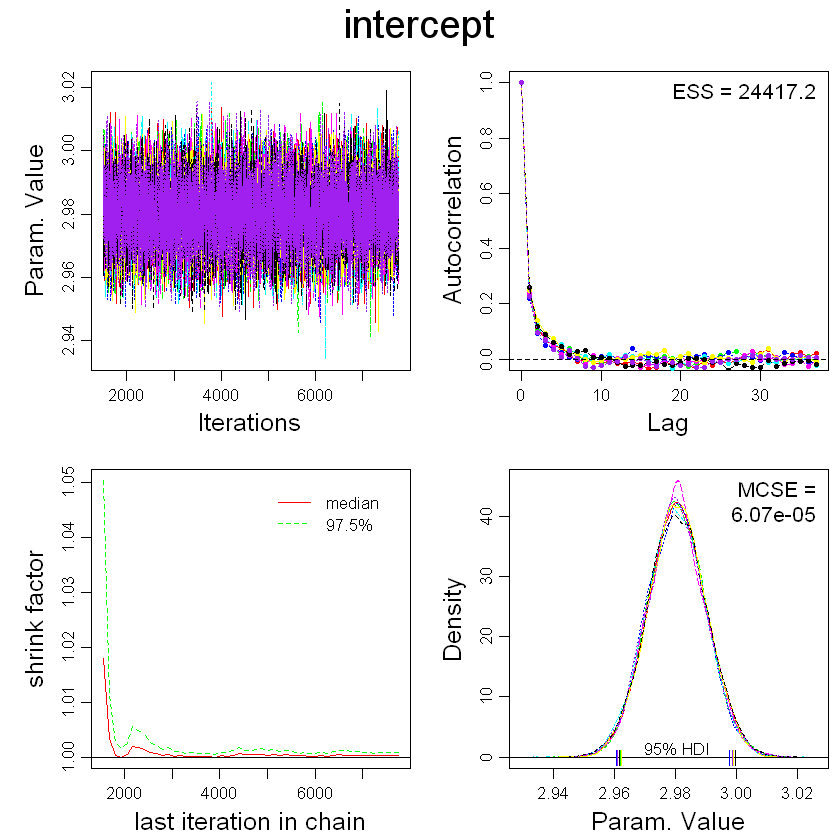

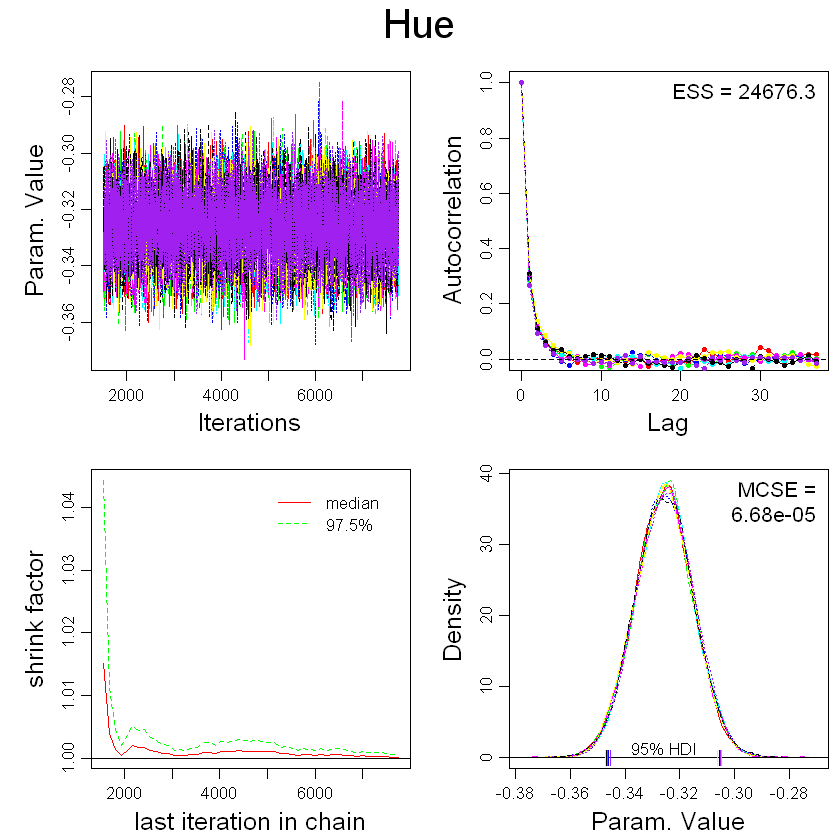

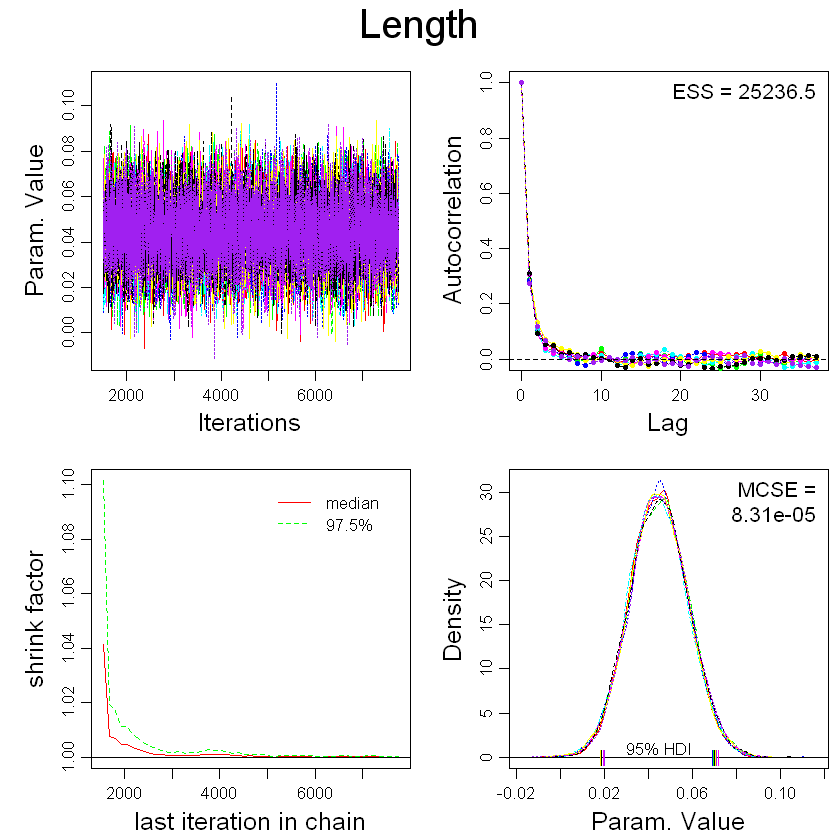

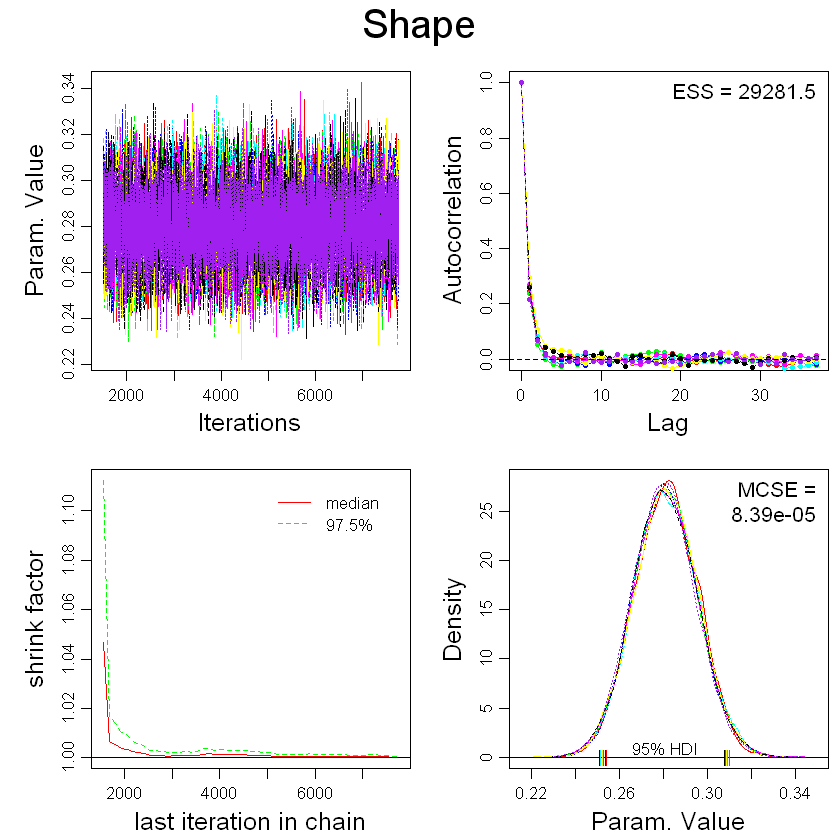

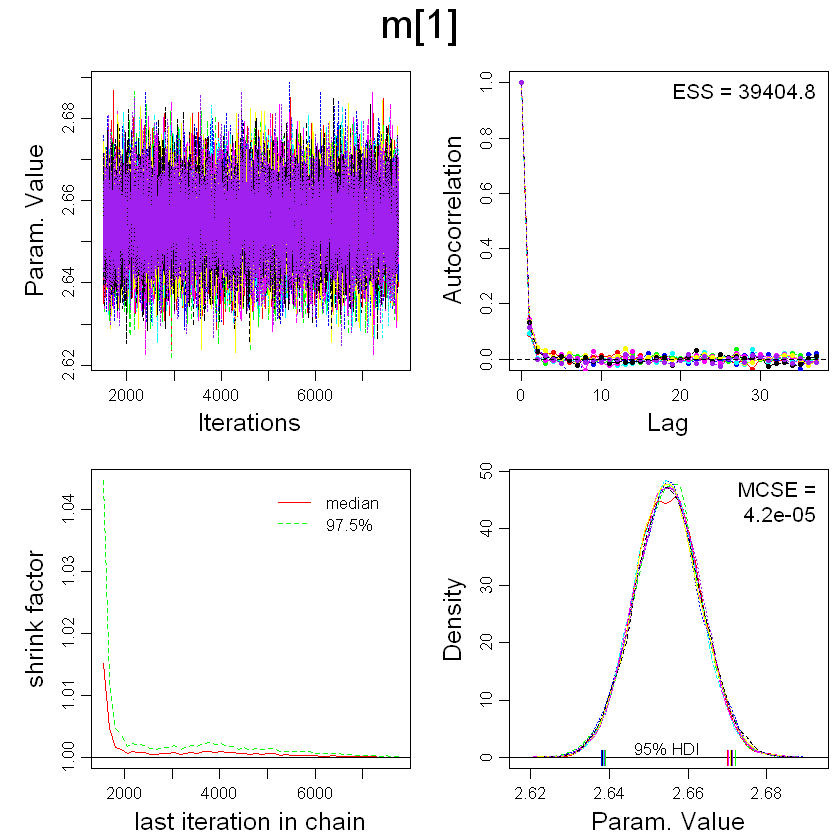

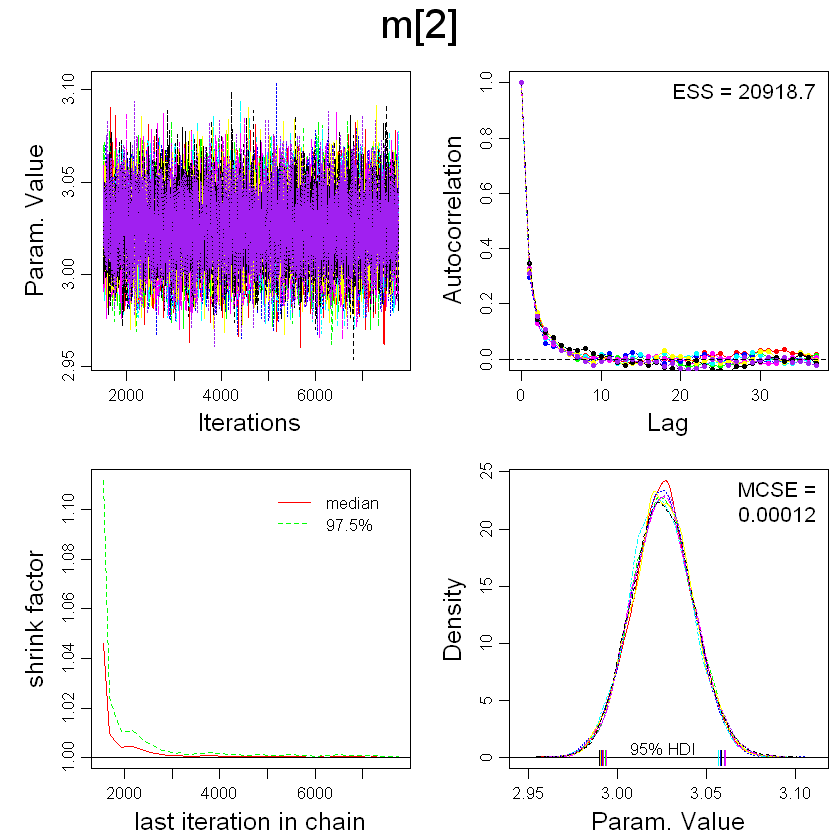

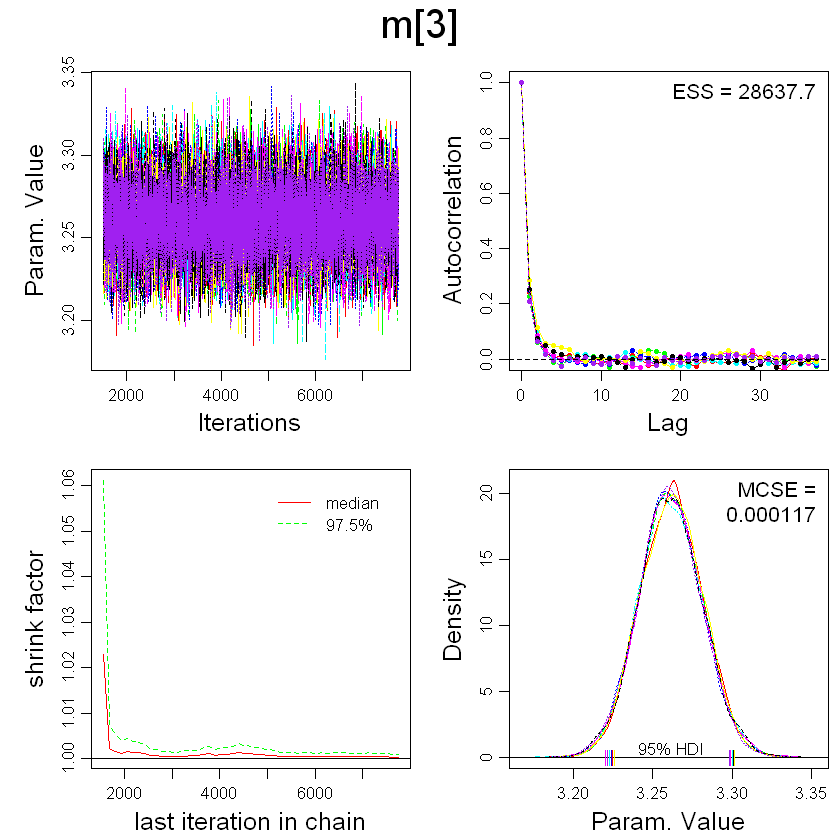

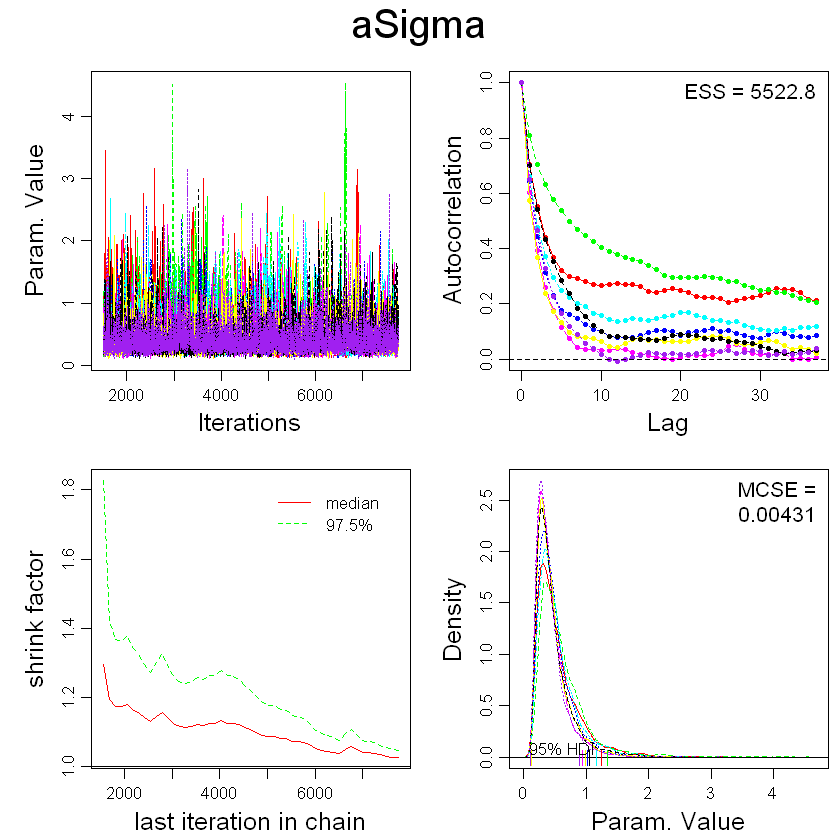

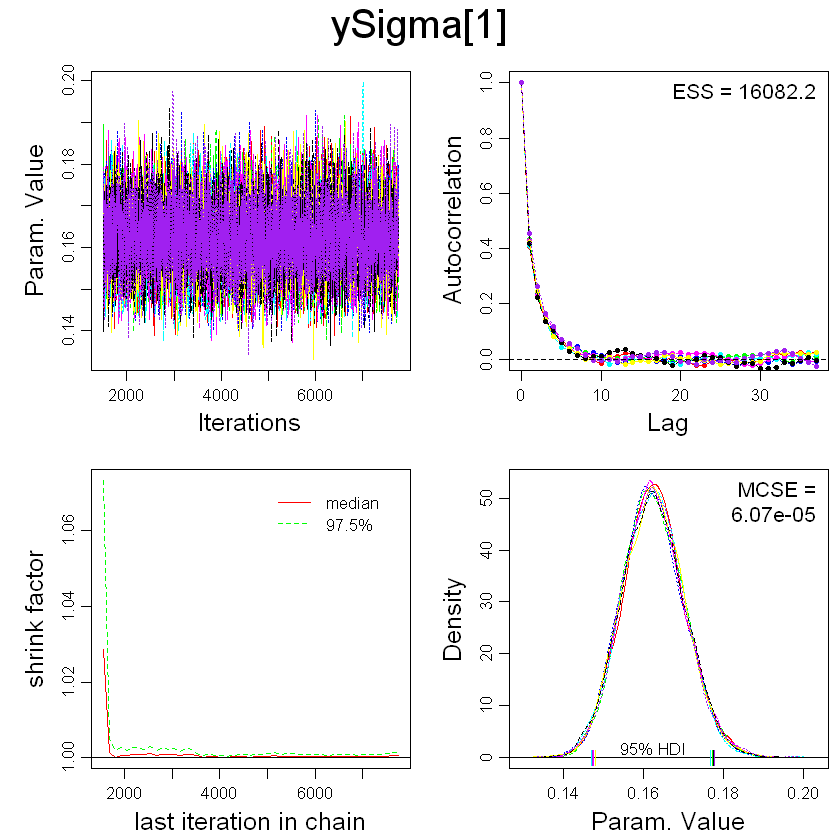

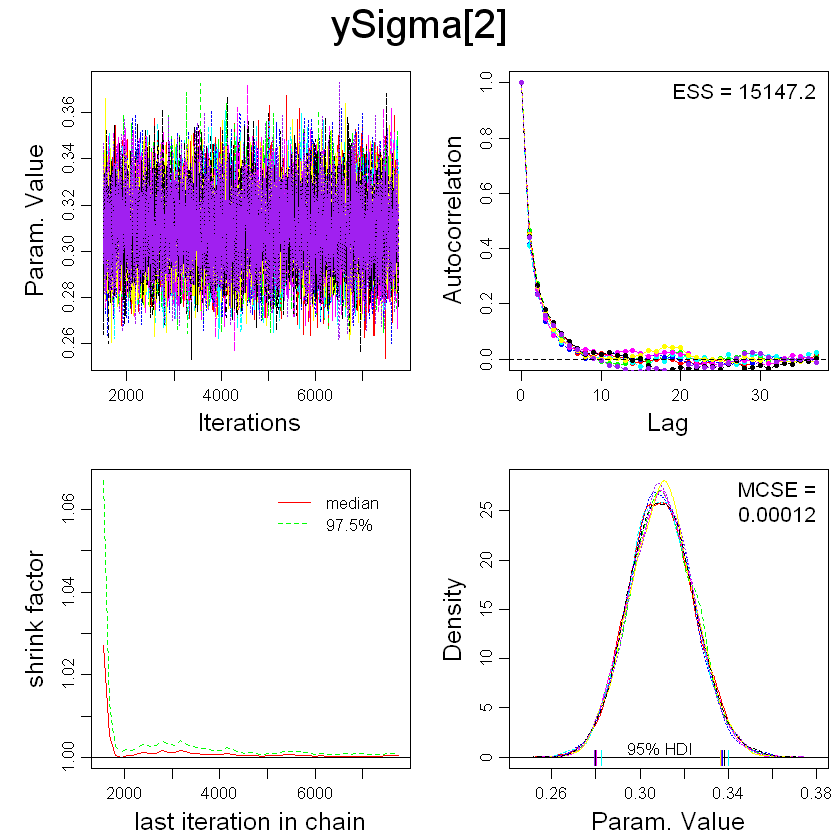

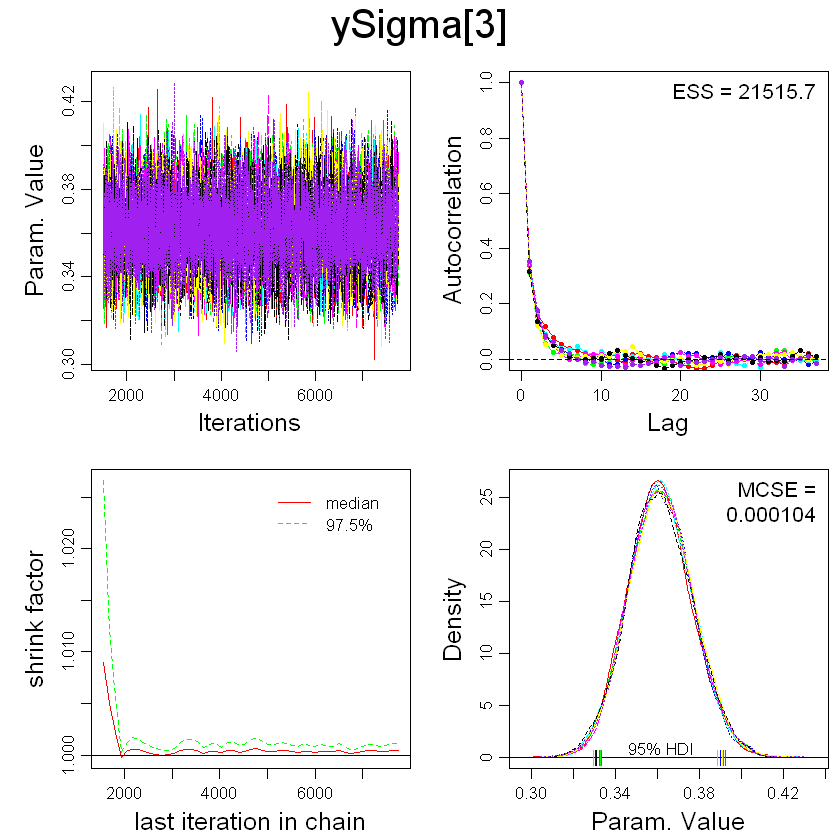

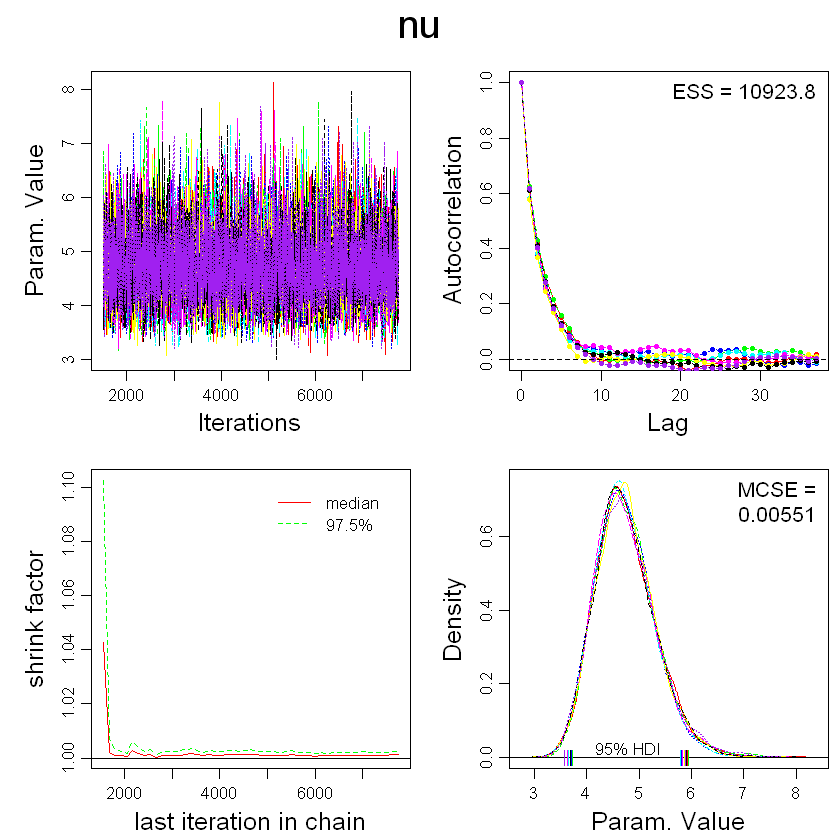

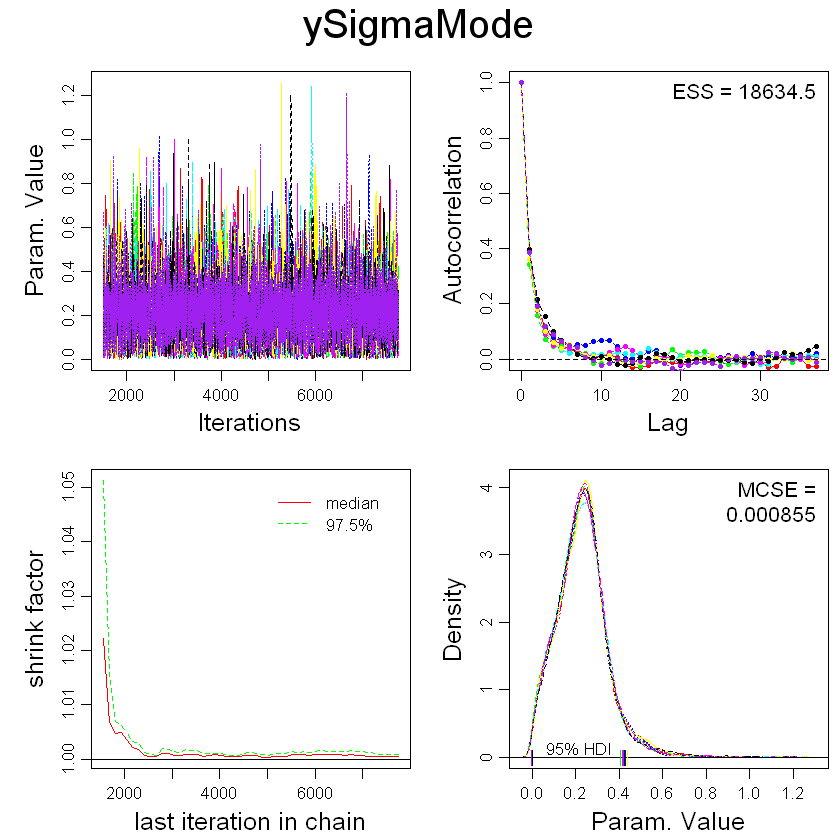

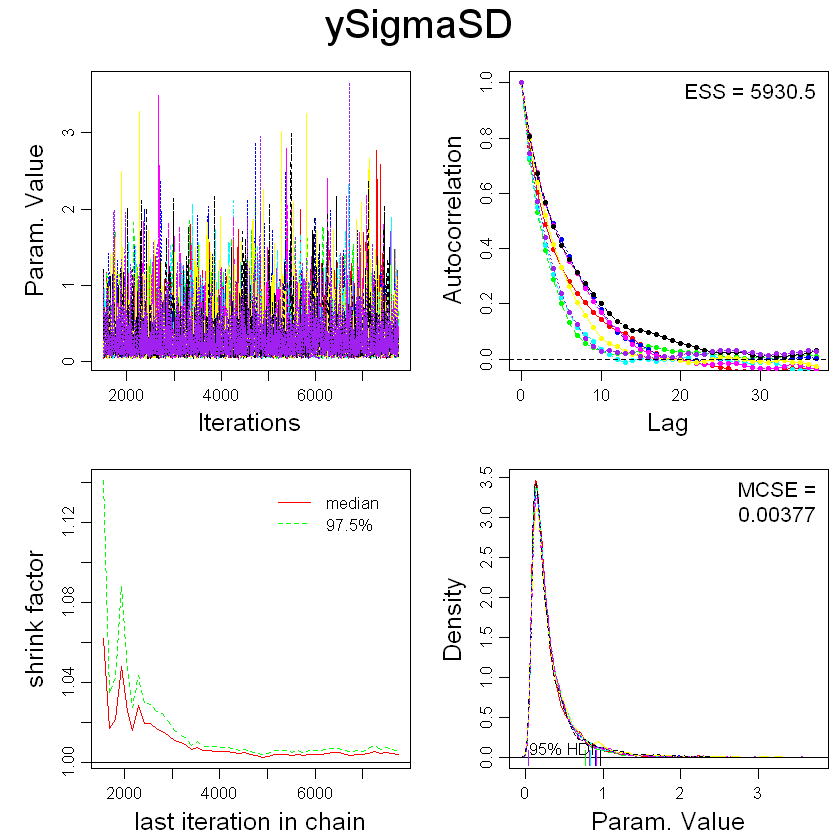

In [24]:
drawDetailedGraphs = FALSE
mcmcCoda = runMCMC(data=featureDataList,modelString=oneFactorModel,
                            parameters=featureParameters,
                            parNames=NULL,
                            thinSteps=1,
                            testName=fatureFileName,
                            mcmcDir=mcmcDir,
                            resultsDir=resultsDir
                            # showPostGraphs = drawDetailedGraphs,
                            # savePostGraphs = drawDetailedGraphs,
                            # showDiag = drawDetailedGraphs,
                            # saveDiag = drawDetailedGraphs
                            )

summaryInfo = smryMCMC(mcmcCoda, datFrm=df, xName=xName)
show(summaryInfo)
parameterNames = varnames(mcmcCoda) 
show( parameterNames ) # show all parameter names, for reference
featureAltParNames = c("intercept", features, "m[1]", "m[2]","m[3]","aSigma" ,
                  "ySigma[1]" ,"ySigma[2]" ,"ySigma[3]" , "nu" , "ySigmaMode" , "ySigmaSD")
for (i in 1:length(parameterNames)) 
{
    diagMCMC( codaObject=mcmcCoda , parName=parameterNames[i], parAltName=featureAltParNames[i])
}

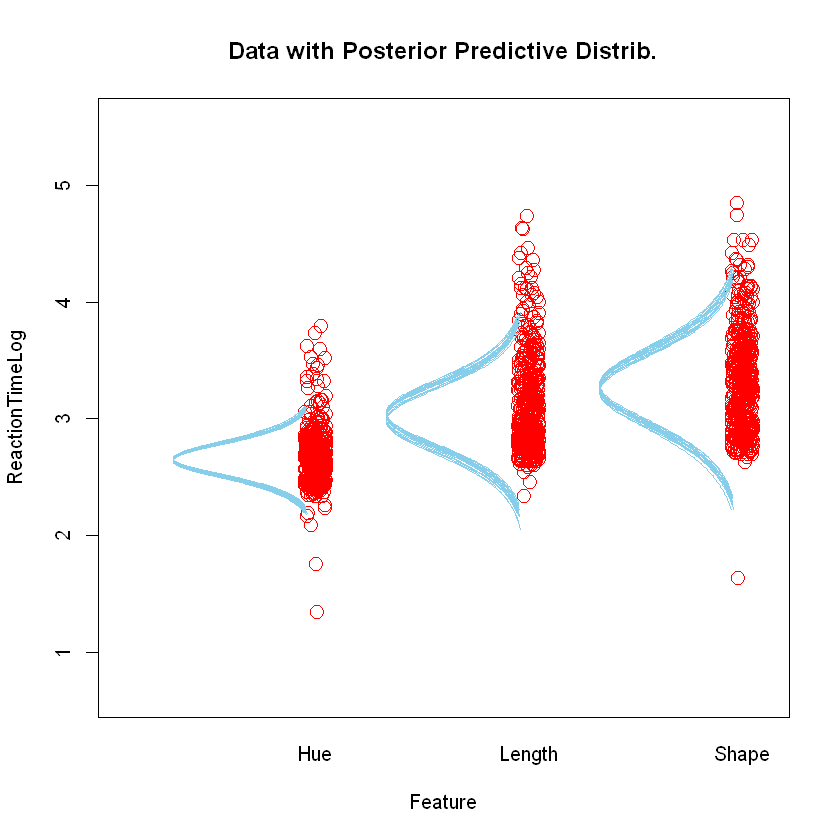

In [23]:
plotMCMC( mcmcCoda , datFrm=df , yName=yName , xName=xName)

## 10). Plot contrasts

 chr [1:3] "Hue" "Length" "Shape"
[1] "Hue - Length probVar1Larger: 0"


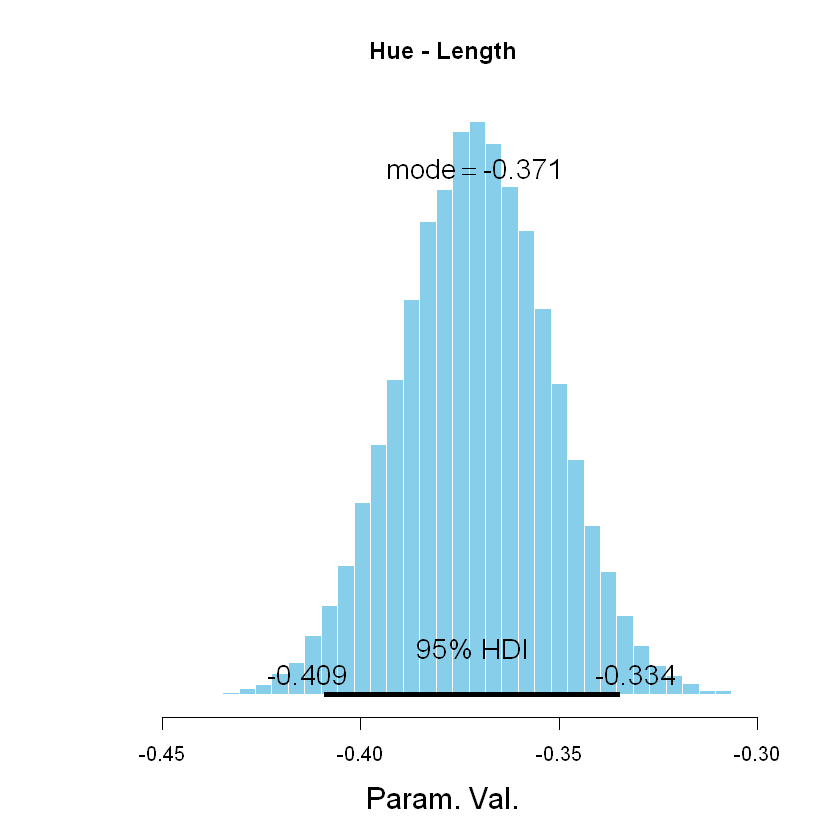

[1] "Hue - Shape probVar1Larger: 0"


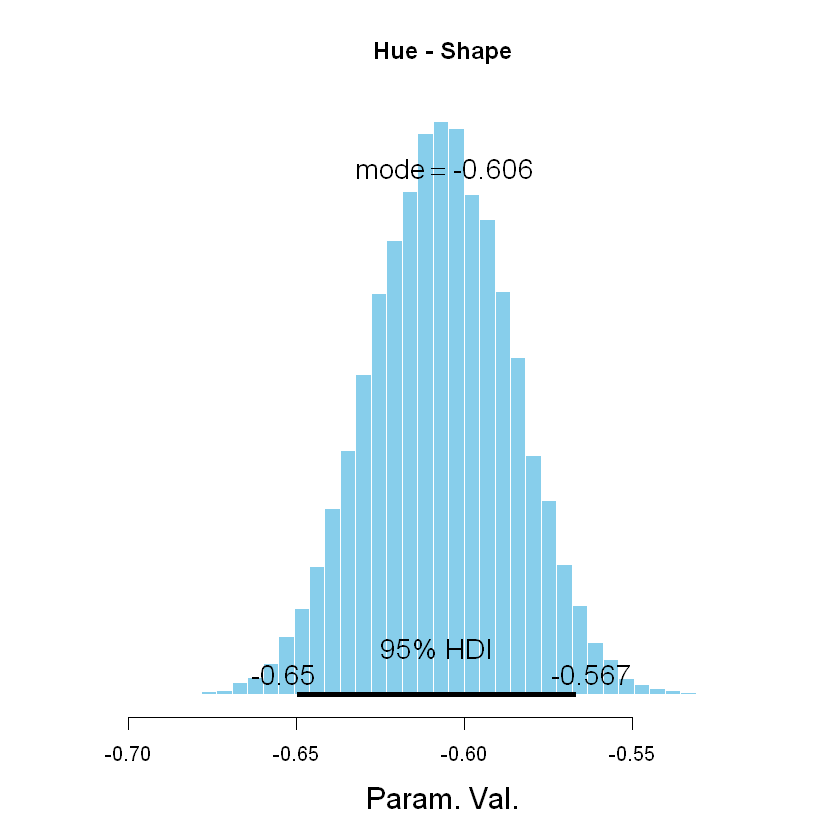

[1] "Length - Shape probVar1Larger: 0"
List of 3
 $ Hue   :List of 2
  ..$ Length:List of 1
  .. ..$ probVar1Larger: num 0
  ..$ Shape :List of 1
  .. ..$ probVar1Larger: num 0
 $ Length:List of 1
  ..$ Shape:List of 1
  .. ..$ probVar1Larger: num 0
 $ Shape : list()


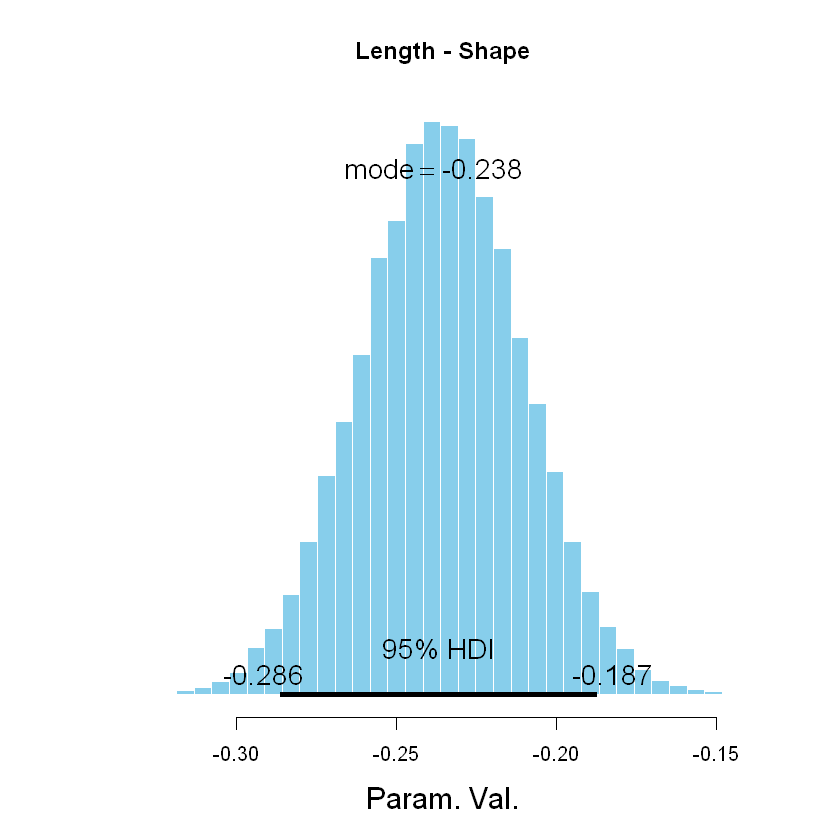

In [11]:
timeLogNumericOutput = calcAndPlotContrasts(mcmcCoda,df,xName)
str(timeLogNumericOutput)